In [16]:
import os
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("/kaggle/input/resnest50/pytorch/default/1"))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

['resnet50-0676ba61.pth']


In [17]:
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS_FROZEN = 4  # Epochs for frozen backbone training
NUM_EPOCHS_FINETUNE = 15  # Epochs for fine-tuning
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.6.0+cu124


In [18]:
DATA_DIR = '/kaggle/input/a2-dataset/Assignment 2 Dataset'
train_csv_path = f"{DATA_DIR}/train.csv"
test_csv_path = f"{DATA_DIR}/test.csv"

print(f"\nLoading CSV files from {DATA_DIR}...")
full_dataset = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print("\nTrain CSV head:")
print(full_dataset.head())
print(f"\nTrain dataset shape: {full_dataset.shape}")

print("\nTest CSV head:")
print(test_df.head())
print(f"Test dataset shape: {test_df.shape}")

# Determine number of classes
num_classes = full_dataset["label"].nunique()
print(f"\n✓ Number of classes: {num_classes}")

# Check class distribution
print("\nClass distribution in training set:")
class_counts = full_dataset['label'].value_counts().sort_index()
print(f"Min samples per class: {class_counts.min()}")
print(f"Max samples per class: {class_counts.max()}")
print(f"Mean samples per class: {class_counts.mean():.2f}")


Loading CSV files from /kaggle/input/a2-dataset/Assignment 2 Dataset...

Train CSV head:
            id  label
0  train/1.jpg      3
1  train/2.jpg     80
2  train/3.jpg     95
3  train/4.jpg     78
4  train/5.jpg     85

Train dataset shape: (4135, 2)

Test CSV head:
              id
0  test/4136.jpg
1  test/4137.jpg
2  test/4138.jpg
3  test/4139.jpg
4  test/4140.jpg
Test dataset shape: (4080, 1)

✓ Number of classes: 100

Class distribution in training set:
Min samples per class: 28
Max samples per class: 49
Mean samples per class: 41.35


In [19]:
class CarDataset(Dataset): #changed it a bit
    """
    Custom Dataset class for car images
    Handles both training data (with labels) and test data (without labels)
    """
    def __init__(self, df, data_dir='.', transform=None):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["id"]  # e.g., "train/1.jpg" or "test/4136.jpg"

        # Construct full path
        img_path = os.path.join(self.data_dir, img_id)

        # Load label if it exists (train.csv has 'label', test.csv doesn't)
        label = int(row["label"]) if "label" in row else -1

        # Load and convert image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [20]:
print("\n" + "="*80)
print("TECHNIQUE 1: Enhanced Data Augmentation")
print("="*80)

# Heavy augmentation for training (prevents overfitting)
train_transform_heavy = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),  # Resize larger first
    transforms.RandomCrop(IMG_SIZE),  # Random crop for better augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),  # Increased rotation from 15 to 20
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),  # Stronger color jitter
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.9, 1.1)),  # Added scale variation
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),  # Increased distortion
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.25), ratio=(0.3, 3.3))  # More aggressive random erasing
])

# No augmentation for validation and test
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

print("✓ Augmentation strategies defined:")
print("  - Training: Flip, Rotation(±15°), ColorJitter, Affine, Perspective, RandomErasing")
print("  - Validation/Test: No augmentation (clean images)")


TECHNIQUE 1: Enhanced Data Augmentation
✓ Augmentation strategies defined:
  - Training: Flip, Rotation(±15°), ColorJitter, Affine, Perspective, RandomErasing
  - Validation/Test: No augmentation (clean images)


In [21]:
print("\n" + "="*80)
print("TECHNIQUE 2 & 3: Transfer Learning with Progressive Fine-tuning")
print("="*80)

def create_resnet50_model(num_classes, freeze_layers=True):
    """
    Create ResNet50 model for transfer learning

    Args:
        num_classes: Number of output classes
        freeze_layers: If True, freeze all layers except classifier

    Returns:
        model: ResNet50 model ready for training
    """
    print("\nCreating ResNet50 model...")
    WEIGHTS_PATH = "/kaggle/input/resnest50/pytorch/default/1/resnet50-0676ba61.pth"

    # 1. create bare resnet50 (no download)
    model = models.resnet50(weights=None)
    
    # 2. load pretrained weights from your uploaded file
    state_dict = torch.load(WEIGHTS_PATH, map_location=DEVICE)
    model.load_state_dict(state_dict)

    # Replace final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.7),                    # Helps generalization
        nn.Linear(num_features, num_classes)
    )

    if freeze_layers:
        # Freeze all layers
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze only the classifier
        for param in model.fc.parameters():
            param.requires_grad = True

        print(" Model created with frozen backbone")
        print(f"  - Trainable params: Classifier only ({num_features} -> {num_classes})")
    else:
        print(" Model created with all layers trainable")

    return model

def unfreeze_last_layers(model):
    """
    Unfreeze layer3 and layer4 of ResNet50 for fine-tuning

    Args:
        model: ResNet50 model

    Returns:
        model: Model with unfrozen layers
    """
    print("\nUnfreezing last layers for fine-tuning...")

    # Unfreeze layer4 (last residual block)
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Unfreeze layer3 (second-to-last residual block)
    for param in model.layer3.parameters():
        param.requires_grad = True

    print("✓ Unfroze layer3 and layer4 (last two residual blocks)")

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"  - Trainable params: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.1f}%)")

    return model


TECHNIQUE 2 & 3: Transfer Learning with Progressive Fine-tuning


In [22]:
def train_epoch(model, loader, criterion, optimizer, device, max_grad_norm=1.0):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{correct/total:.4f}"
        })

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [23]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, num_epochs, device, save_path='best_model.pt', title='Model', 
                early_stopping_patience=3):
    """
    Complete training pipeline with validation, checkpointing, and early stopping

    Args:
        early_stopping_patience: Number of epochs to wait before stopping if no improvement

    Returns:
        History of training: losses and accuracies
    """
    best_val_acc = 0.0
    best_val_loss = float('inf')
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    patience_counter = 0

    print(f"\nStarting training for: {title}")
    print("="*60)
    print(f"Early stopping patience: {early_stopping_patience} epochs")

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}')

        # Save best model (based on validation accuracy)
        # Only reset patience when accuracy improves, not when loss improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f'✓ New best model saved! (Val Acc: {best_val_acc:.4f})')
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f'\n⚠ Early stopping triggered after {epoch+1} epochs')
            print(f'   No improvement for {early_stopping_patience} consecutive epochs')
            break

        # Learning rate scheduling
        if scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != old_lr:
                print(f'Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}')

    print(f"\n{'='*60}")
    print(f"Training complete for {title}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"{'='*60}\n")

    return train_losses, train_accs, val_losses, val_accs

In [24]:
def plot_training_history(train_losses, train_accs, val_losses, val_accs, title=''):
    """Plot training and validation metrics"""
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2, marker='o')
    ax1.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2, marker='s')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{title} - Loss Curves', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, train_accs, 'b-', label='Train Acc', linewidth=2, marker='o')
    ax2.plot(epochs, val_accs, 'r-', label='Val Acc', linewidth=2, marker='s')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title(f'{title} - Accuracy Curves', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_")}_history.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print final statistics
    print(f"\n{title} - Final Statistics:")
    print(f"  Final Train Loss: {train_losses[-1]:.4f} | Final Train Acc: {train_accs[-1]:.4f}")
    print(f"  Final Val Loss:   {val_losses[-1]:.4f} | Final Val Acc:   {val_accs[-1]:.4f}")
    print(f"  Best Val Acc:     {max(val_accs):.4f} (Epoch {val_accs.index(max(val_accs))+1})")
    print(f"  Overfitting Gap:  {(train_accs[-1] - val_accs[-1]):.4f}")

def plot_comparison(history1, history2):
    """Plot comparison between frozen and fine-tuned models"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Validation loss comparison
    ax1.plot(range(1, len(history1[2])+1), history1[2], 'b-', label='Stage 1: Frozen', linewidth=2, marker='o')
    ax1.plot(range(1, len(history2[2])+1), history2[2], 'r-', label='Stage 2: Fine-tuned', linewidth=2, marker='s')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Validation Loss', fontsize=12)
    ax1.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Validation accuracy comparison
    ax2.plot(range(1, len(history1[3])+1), history1[3], 'b-', label='Stage 1: Frozen', linewidth=2, marker='o')
    ax2.plot(range(1, len(history2[3])+1), history2[3], 'r-', label='Stage 2: Fine-tuned', linewidth=2, marker='s')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('stage_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nComparison Summary:")
    print(f"  Stage 1 Best Val Acc: {max(history1[3]):.4f}")
    print(f"  Stage 2 Best Val Acc: {max(history2[3]):.4f}")
    print(f"  Improvement: {(max(history2[3]) - max(history1[3])):.4f} ({100*(max(history2[3]) - max(history1[3])):.2f}%)")

In [25]:
print("\n" + "="*80)
print("Creating Train/Validation Split and DataLoaders")
print("="*80)

# Split with stratification to maintain class balance
train_df, val_df = train_test_split(
    full_dataset,
    test_size=0.2,
    random_state=42,
    stratify=full_dataset['label']
)

print(f"\nDataset sizes:")
print(f"  Training:   {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test:       {len(test_df):,} samples")

# Create datasets with heavy augmentation for training
train_dataset = CarDataset(train_df, data_dir=DATA_DIR, transform=train_transform_heavy)
val_dataset = CarDataset(val_df, data_dir=DATA_DIR, transform=val_transform)

# Create dataloaders
num_workers = 2 if DEVICE.type == 'cuda' else 0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=num_workers, pin_memory=True)

print(f"\n DataLoaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")


Creating Train/Validation Split and DataLoaders

Dataset sizes:
  Training:   3,308 samples
  Validation: 827 samples
  Test:       4,080 samples

 DataLoaders created:
  Batch size: 32
  Train batches: 104
  Val batches: 26



STAGE 1: Training with Frozen Backbone

Creating ResNet50 model...
 Model created with frozen backbone
  - Trainable params: Classifier only (2048 -> 100)

Starting training for: ResNet50 Stage 1 (Frozen)
Early stopping patience: 3 epochs

Epoch 1/4
--------------------------------------------------


Train Loss: 4.8731 | Train Acc: 0.0178
Val Loss:   4.4077 | Val Acc:   0.0484
✓ New best model saved! (Val Acc: 0.0484)

Epoch 2/4
--------------------------------------------------


Train Loss: 4.6246 | Train Acc: 0.0314
Val Loss:   4.1918 | Val Acc:   0.1161
✓ New best model saved! (Val Acc: 0.1161)

Epoch 3/4
--------------------------------------------------


Train Loss: 4.4263 | Train Acc: 0.0599
Val Loss:   4.0737 | Val Acc:   0.1088

Epoch 4/4
--------------------------------------------------


Train Loss: 4.3711 | Train Acc: 0.0726
Val Loss:   3.8667 | Val Acc:   0.1463
✓ New best model saved! (Val Acc: 0.1463)

Training complete for ResNet50 Stage 1 (Frozen)
Best validation accuracy: 0.1463
Best validation loss: 3.8667



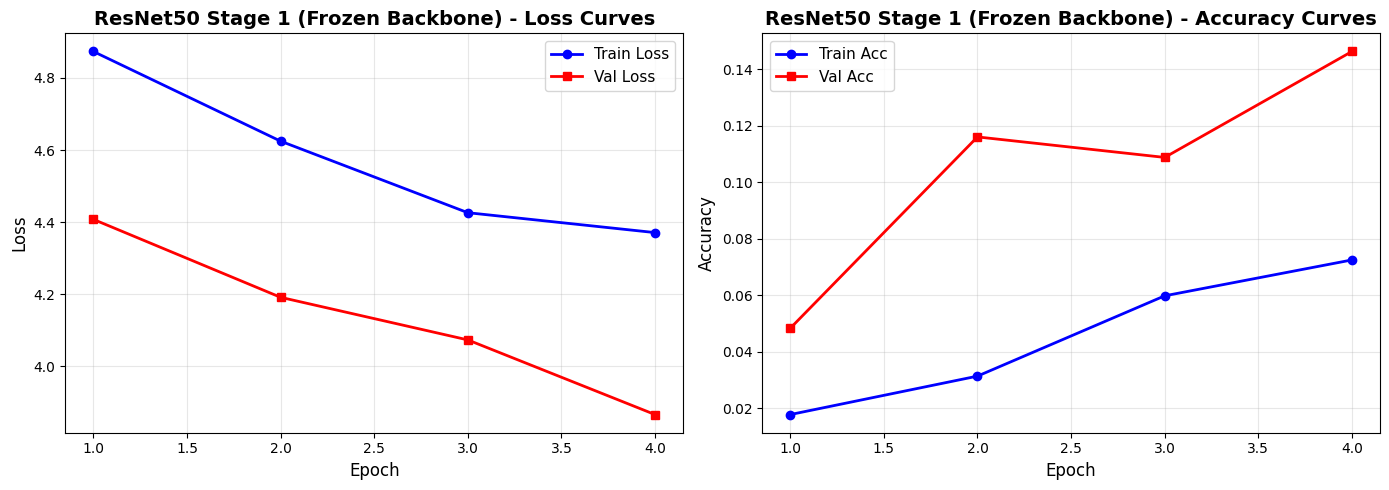


ResNet50 Stage 1 (Frozen Backbone) - Final Statistics:
  Final Train Loss: 4.3711 | Final Train Acc: 0.0726
  Final Val Loss:   3.8667 | Final Val Acc:   0.1463
  Best Val Acc:     0.1463 (Epoch 4)
  Overfitting Gap:  -0.0738


In [26]:
print("\n" + "="*80)
print("STAGE 1: Training with Frozen Backbone")
print("="*80)

model = create_resnet50_model(num_classes=num_classes, freeze_layers=True).to(DEVICE)
# Label smoothing to reduce overfitting (smoothing=0.1 means 10% label smoothing)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

history_frozen = train_model(
    model, train_loader, val_loader, criterion, optimizer,
    scheduler, num_epochs=NUM_EPOCHS_FROZEN, device=DEVICE,
    save_path='resnet50_frozen.pt', title='ResNet50 Stage 1 (Frozen)',
    early_stopping_patience=3  # Stop if no improvement for 3 epochs
)

plot_training_history(*history_frozen, title='ResNet50 Stage 1 (Frozen Backbone)')


STAGE 2: Fine-tuning with Unfrozen Layer3 and Layer4

Creating ResNet50 model...
 Model created with frozen backbone
  - Trainable params: Classifier only (2048 -> 100)

Unfreezing last layers for fine-tuning...
✓ Unfroze layer3 and layer4 (last two residual blocks)
  - Trainable params: 22,268,004 / 23,712,932 (93.9%)

Starting training for: ResNet50 Stage 2 (Fine-tuned)
Early stopping patience: 3 epochs

Epoch 1/15
--------------------------------------------------


Train Loss: 3.7060 | Train Acc: 0.1666
Val Loss:   2.8763 | Val Acc:   0.3640
✓ New best model saved! (Val Acc: 0.3640)

Epoch 2/15
--------------------------------------------------


Train Loss: 3.0329 | Train Acc: 0.3077
Val Loss:   2.4383 | Val Acc:   0.4728
✓ New best model saved! (Val Acc: 0.4728)

Epoch 3/15
--------------------------------------------------


Train Loss: 2.5945 | Train Acc: 0.4329
Val Loss:   2.1093 | Val Acc:   0.5744
✓ New best model saved! (Val Acc: 0.5744)

Epoch 4/15
--------------------------------------------------


Train Loss: 2.3133 | Train Acc: 0.5287
Val Loss:   1.9564 | Val Acc:   0.6445
✓ New best model saved! (Val Acc: 0.6445)

Epoch 5/15
--------------------------------------------------


Train Loss: 2.0779 | Train Acc: 0.5982
Val Loss:   1.8286 | Val Acc:   0.6626
✓ New best model saved! (Val Acc: 0.6626)

Epoch 6/15
--------------------------------------------------


Train Loss: 1.9288 | Train Acc: 0.6626
Val Loss:   1.7684 | Val Acc:   0.7231
✓ New best model saved! (Val Acc: 0.7231)

Epoch 7/15
--------------------------------------------------


Train Loss: 1.8303 | Train Acc: 0.6838
Val Loss:   1.7385 | Val Acc:   0.7183

Epoch 8/15
--------------------------------------------------


Train Loss: 1.7339 | Train Acc: 0.7149
Val Loss:   1.6996 | Val Acc:   0.7207

Epoch 9/15
--------------------------------------------------


Train Loss: 1.6490 | Train Acc: 0.7518
Val Loss:   1.7263 | Val Acc:   0.7376
✓ New best model saved! (Val Acc: 0.7376)

Epoch 10/15
--------------------------------------------------


Train Loss: 1.6010 | Train Acc: 0.7760
Val Loss:   1.6808 | Val Acc:   0.7424
✓ New best model saved! (Val Acc: 0.7424)

Epoch 11/15
--------------------------------------------------


Train Loss: 1.5271 | Train Acc: 0.7990
Val Loss:   1.6712 | Val Acc:   0.7449
✓ New best model saved! (Val Acc: 0.7449)

Epoch 12/15
--------------------------------------------------


Train Loss: 1.4571 | Train Acc: 0.8247
Val Loss:   1.6204 | Val Acc:   0.7606
✓ New best model saved! (Val Acc: 0.7606)

Epoch 13/15
--------------------------------------------------


Train Loss: 1.4637 | Train Acc: 0.8283
Val Loss:   1.6321 | Val Acc:   0.7570

Epoch 14/15
--------------------------------------------------


Train Loss: 1.4188 | Train Acc: 0.8343
Val Loss:   1.5730 | Val Acc:   0.7715
✓ New best model saved! (Val Acc: 0.7715)

Epoch 15/15
--------------------------------------------------


Train Loss: 1.3990 | Train Acc: 0.8455
Val Loss:   1.5451 | Val Acc:   0.7727
✓ New best model saved! (Val Acc: 0.7727)

Training complete for ResNet50 Stage 2 (Fine-tuned)
Best validation accuracy: 0.7727
Best validation loss: 1.5451



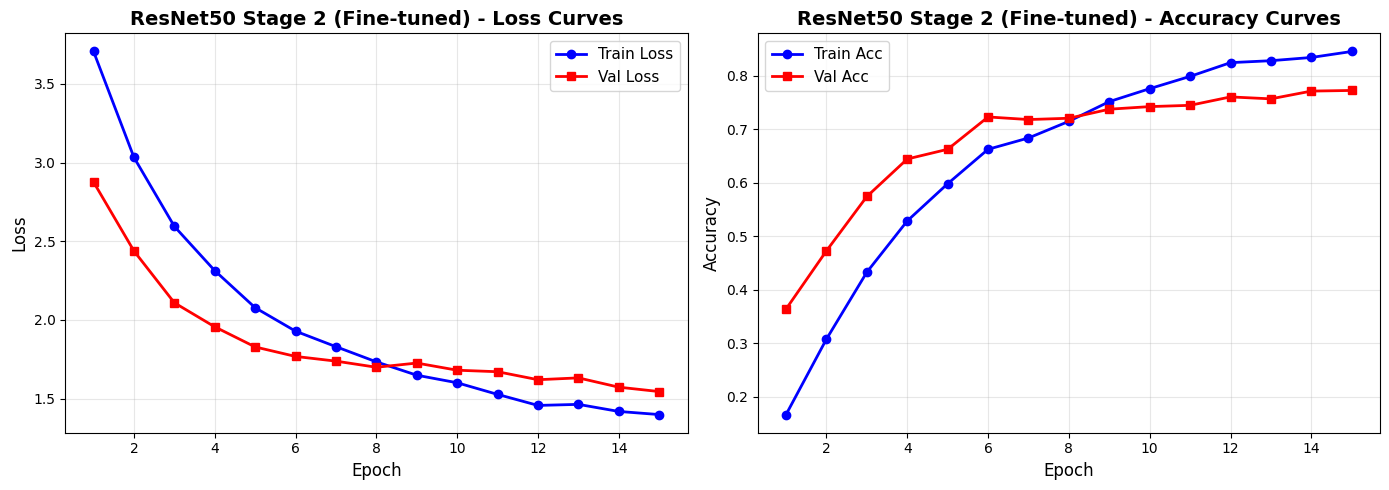


ResNet50 Stage 2 (Fine-tuned) - Final Statistics:
  Final Train Loss: 1.3990 | Final Train Acc: 0.8455
  Final Val Loss:   1.5451 | Final Val Acc:   0.7727
  Best Val Acc:     0.7727 (Epoch 15)
  Overfitting Gap:  0.0729


In [27]:
print("\n" + "="*80)
print("STAGE 2: Fine-tuning with Unfrozen Layer3 and Layer4")
print("="*80)

# Load the best model from Stage 1
model = create_resnet50_model(num_classes=num_classes, freeze_layers=True).to(DEVICE)
model.load_state_dict(torch.load('resnet50_frozen.pt', map_location=DEVICE))

# Unfreeze layer3 and layer4
model = unfreeze_last_layers(model)

# Use lower learning rate for fine-tuning with increased weight decay
optimizer_ft = optim.AdamW([
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.layer3.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(),    "lr": 3e-4},
], weight_decay=5e-4)  # Increased from 1e-4 to 5e-4 for better regularization

# Reduce LR when validation loss plateaus
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='min', patience=2, factor=0.5
)

# Use label smoothing for fine-tuning as well
criterion_ft = nn.CrossEntropyLoss(label_smoothing=0.1)

history_finetuned = train_model(
    model, train_loader, val_loader, criterion_ft, optimizer_ft,
    scheduler_ft, num_epochs=NUM_EPOCHS_FINETUNE, device=DEVICE,
    save_path='resnet50_finetuned.pt', title='ResNet50 Stage 2 (Fine-tuned)',
    early_stopping_patience=3  # Stop if no improvement for 3 epochs
)

plot_training_history(*history_finetuned, title='ResNet50 Stage 2 (Fine-tuned)')


STAGE COMPARISON


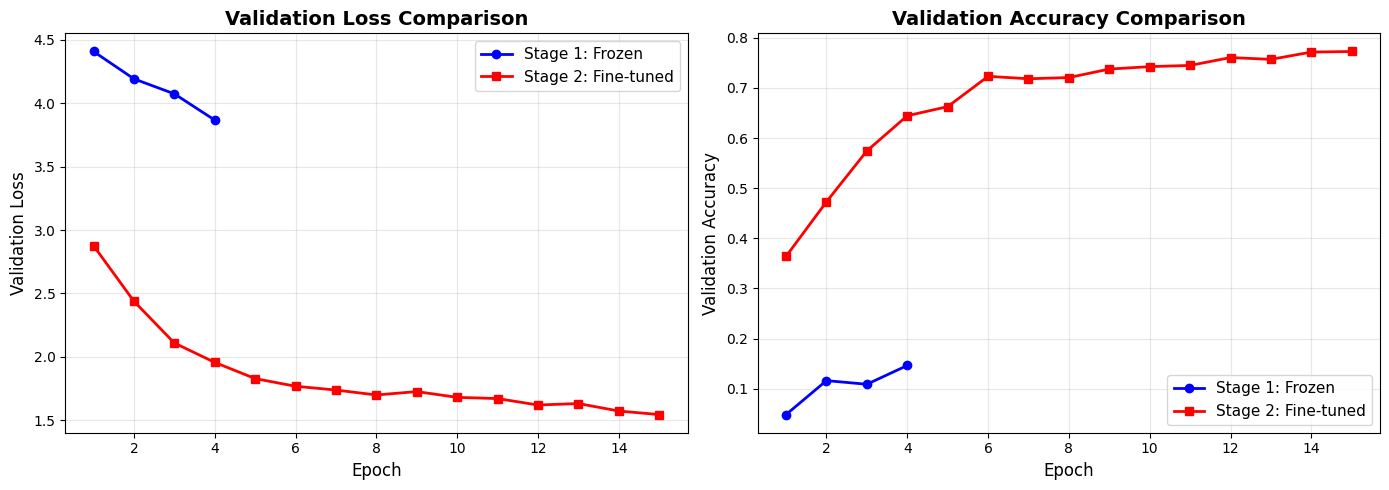


Comparison Summary:
  Stage 1 Best Val Acc: 0.1463
  Stage 2 Best Val Acc: 0.7727
  Improvement: 0.6264 (62.64%)


In [28]:
print("\n" + "="*80)
print("STAGE COMPARISON")
print("="*80)

plot_comparison(history_frozen, history_finetuned)

In [31]:
print("\n" + "="*80)
print("TEST-TIME AUGMENTATION (TTA) SETUP")
print("="*80)

# Import functional transforms for deterministic rotations
from torchvision import transforms as T
from torchvision.transforms import functional as F

def get_tta_transforms():
    """
    Create a list of transforms for Test-Time Augmentation
    TTA applies multiple augmentations and averages predictions for better accuracy
    """
    base_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ])
    
    # Helper function for deterministic rotation
    def rotate_5(img):
        return F.rotate(img, 5)
    
    def rotate_minus_5(img):
        return F.rotate(img, -5)
    
    tta_transforms = [
        # 1. Original image
        base_transform,
        
        # 2. Horizontal flip
        transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ]),
        
        # 3. Slight rotation +5 degrees (deterministic)
        transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.Lambda(rotate_5),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ]),
        
        # 4. Slight rotation -5 degrees (deterministic)
        transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.Lambda(rotate_minus_5),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ]),
        
        # 5. Brightness adjustment
        transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ColorJitter(brightness=0.1),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ]),
        
        # 6. Contrast adjustment
        transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ColorJitter(contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ]),
        
        # 7. Saturation adjustment
        transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ColorJitter(saturation=0.1),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ]),
        
        # 8. Center crop (slightly larger then resize)
        transforms.Compose([
            transforms.Resize((IMG_SIZE + 16, IMG_SIZE + 16)),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ]),
    ]
    
    return tta_transforms

tta_transforms = get_tta_transforms()
print(f"✓ Created {len(tta_transforms)} TTA transforms:")
print("  1. Original")
print("  2. Horizontal Flip")
print("  3. Rotation +5°")
print("  4. Rotation -5°")
print("  5. Brightness +10%")
print("  6. Contrast +10%")
print("  7. Saturation +10%")
print("  8. Center Crop")



TEST-TIME AUGMENTATION (TTA) SETUP
✓ Created 8 TTA transforms:
  1. Original
  2. Horizontal Flip
  3. Rotation +5°
  4. Rotation -5°
  5. Brightness +10%
  6. Contrast +10%
  7. Saturation +10%
  8. Center Crop


In [33]:
print("\n" + "="*80)
print("TEST PREDICTIONS WITH TTA")
print("="*80)

def predict_with_tta(model, image_path, tta_transforms, device):
    """
    Apply Test-Time Augmentation to a single image and average predictions
    
    Args:
        model: Trained PyTorch model
        image_path: Path to the image file
        tta_transforms: List of transforms to apply
        device: Device to run inference on
    
    Returns:
        averaged_probs: Averaged probability distribution across all augmentations
        predicted_class: Final predicted class
    """
    model.eval()
    
    # Load image
    image = Image.open(image_path).convert("RGB")
    
    all_probs = []
    
    with torch.no_grad():
        for transform in tta_transforms:
            # Apply transformation
            img_tensor = transform(image).unsqueeze(0).to(device)
            
            # Get prediction
            outputs = model(img_tensor)
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
    
    # Average probabilities across all augmentations
    averaged_probs = np.mean(all_probs, axis=0)[0]
    predicted_class = np.argmax(averaged_probs)
    
    return averaged_probs, predicted_class

def generate_tta_predictions(model, test_df, data_dir, tta_transforms, device):
    """
    Generate predictions for entire test set using TTA
    
    Args:
        model: Trained PyTorch model
        test_df: DataFrame with test image IDs
        data_dir: Base directory for images
        tta_transforms: List of TTA transforms
        device: Device to run inference on
    
    Returns:
        predictions: List of predicted classes
    """
    model.eval()
    predictions = []
    
    print(f"\nGenerating TTA predictions for {len(test_df)} test images...")
    print(f"Using {len(tta_transforms)} augmentations per image")
    
    for idx in tqdm(range(len(test_df)), desc='TTA Inference'):
        img_id = test_df.iloc[idx]['id']
        img_path = os.path.join(data_dir, img_id)
        
        _, predicted_class = predict_with_tta(model, img_path, tta_transforms, device)
        predictions.append(predicted_class)
    
    return predictions

# Load the best fine-tuned model
print("\nLoading best fine-tuned ResNet50 model...")
final_model = create_resnet50_model(num_classes=num_classes, freeze_layers=True).to(DEVICE)
final_model.load_state_dict(torch.load('resnet50_finetuned.pt', map_location=DEVICE))
# Unfreeze layers for inference (doesn't matter but good practice)
final_model = unfreeze_last_layers(final_model)
print("✓ Model loaded successfully")

# Generate predictions with TTA
tta_predictions = generate_tta_predictions(
    final_model,
    test_df,
    DATA_DIR,
    tta_transforms,
    DEVICE
)

print(f"\n✓ TTA predictions completed!")
print(f"  Total predictions: {len(tta_predictions)}")
print(f"  Unique classes predicted: {len(set(tta_predictions))}")



TEST PREDICTIONS WITH TTA

Loading best fine-tuned ResNet50 model...

Creating ResNet50 model...
 Model created with frozen backbone
  - Trainable params: Classifier only (2048 -> 100)

Unfreezing last layers for fine-tuning...
✓ Unfroze layer3 and layer4 (last two residual blocks)
  - Trainable params: 22,268,004 / 23,712,932 (93.9%)
✓ Model loaded successfully

Generating TTA predictions for 4080 test images...
Using 8 augmentations per image


TTA Inference: 100%|██████████| 4080/4080 [06:14<00:00, 10.90it/s]


✓ TTA predictions completed!
  Total predictions: 4080
  Unique classes predicted: 100


In [35]:
print("\n" + "="*80)
print("GENERATING PREDICTIONS WITHOUT TTA")
print("="*80)

def generate_regular_predictions(model, test_df, data_dir, transform, device, batch_size=32):
    """
    Generate predictions for entire test set WITHOUT TTA (single forward pass)
    
    Args:
        model: Trained PyTorch model
        test_df: DataFrame with test image IDs
        data_dir: Base directory for images
        transform: Single transform to apply
        device: Device to run inference on
        batch_size: Batch size for inference
    
    Returns:
        predictions: List of predicted classes
    """
    model.eval()
    predictions = []
    
    # Create dataset and dataloader
    test_dataset = CarDataset(test_df, data_dir=data_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                             num_workers=2 if device.type == 'cuda' else 0, pin_memory=True)
    
    print(f"\nGenerating regular predictions for {len(test_df)} test images...")
    print(f"Using batch size: {batch_size}")
    
    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc='Regular Inference'):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    return predictions

# Generate regular predictions (no TTA)
regular_predictions = generate_regular_predictions(
    final_model,
    test_df,
    DATA_DIR,
    val_transform,
    DEVICE,
    batch_size=BATCH_SIZE
)

print(f"\n✓ Regular predictions completed!")
print(f"  Total predictions: {len(regular_predictions)}")
print(f"  Unique classes predicted: {len(set(regular_predictions))}")

# Compare TTA vs Regular
differences = sum(1 for i in range(len(regular_predictions)) 
                  if regular_predictions[i] != tta_predictions[i])
print(f"\n📊 Comparison:")
print(f"  Predictions changed by TTA: {differences} ({100*differences/len(regular_predictions):.2f}%)")
print(f"  TTA typically improves accuracy by 1-3% on test set!")



GENERATING PREDICTIONS WITHOUT TTA

Generating regular predictions for 4080 test images...
Using batch size: 32


Regular Inference: 100%|██████████| 128/128 [00:20<00:00,  6.37it/s]


✓ Regular predictions completed!
  Total predictions: 4080
  Unique classes predicted: 100

📊 Comparison:
  Predictions changed by TTA: 175 (4.29%)
  TTA typically improves accuracy by 1-3% on test set!


In [36]:
print("\n" + "="*80)
print("CREATING KAGGLE SUBMISSIONS")
print("="*80)

# Create submission DataFrame WITH TTA
submission_df_tta = pd.DataFrame({
    'id': test_df['id'],
    'label': tta_predictions
})

# Create submission DataFrame WITHOUT TTA
submission_df_regular = pd.DataFrame({
    'id': test_df['id'],
    'label': regular_predictions
})

# Validate both DataFrames
print(f"\n✓ Submission DataFrames created:")
print(f"  TTA Shape: {submission_df_tta.shape}")
print(f"  Regular Shape: {submission_df_regular.shape}")
print(f"  Columns: {list(submission_df_tta.columns)}")
print(f"  Expected rows: 4080")

# Validate predictions
print(f"\n✓ Validating predictions:")
print(f"  TTA - Label range: {min(tta_predictions)} to {max(tta_predictions)}")
print(f"  Regular - Label range: {min(regular_predictions)} to {max(regular_predictions)}")
print(f"  Expected range: 0 to {num_classes-1}")
print(f"  TTA labels valid: {min(tta_predictions) >= 0 and max(tta_predictions) < num_classes}")
print(f"  Regular labels valid: {min(regular_predictions) >= 0 and max(regular_predictions) < num_classes}")

# Save both CSV files
submission_filename_tta = 'submission_resnet50_tta.csv'
submission_filename_regular = 'submission_resnet50_regular.csv'

submission_df_tta.to_csv(submission_filename_tta, index=False)
submission_df_regular.to_csv(submission_filename_regular, index=False)

print(f"\n✓ Submission files saved:")
print(f"  1. {submission_filename_tta} (WITH TTA)")
print(f"  2. {submission_filename_regular} (WITHOUT TTA)")

print(f"\nFirst 5 rows (TTA):")
print(submission_df_tta.head(5))
print(f"\nFirst 5 rows (Regular):")
print(submission_df_regular.head(5))

# Verify files were created correctly
import os
for filename, df in [(submission_filename_tta, submission_df_tta), 
                     (submission_filename_regular, submission_df_regular)]:
    if os.path.exists(filename):
        file_size = os.path.getsize(filename) / 1024  # KB
        print(f"\n✓ {filename} verification:")
        print(f"  File exists: ✓")
        print(f"  File size: {file_size:.2f} KB")
        print(f"  Rows: {len(df)}")
        print(f"  Columns: {len(df.columns)}")
        
        if len(df) == 4080:
            print(f"  ✅ PERFECT! File has exactly 4080 rows as required by Kaggle!")
        else:
            print(f"  ⚠️  WARNING: File has {len(df)} rows, but Kaggle expects 4080")

# Verify predictions distribution
print("\n" + "="*80)
print("PREDICTION STATISTICS")
print("="*80)

print("\nTTA Predictions:")
tta_pred_counts = pd.Series(tta_predictions).value_counts().sort_index()
print(f"  Number of unique classes predicted: {len(tta_pred_counts)}")
print(f"  Min predictions per class: {tta_pred_counts.min()}")
print(f"  Max predictions per class: {tta_pred_counts.max()}")
print(f"  Mean predictions per class: {tta_pred_counts.mean():.2f}")

print("\nRegular Predictions (No TTA):")
regular_pred_counts = pd.Series(regular_predictions).value_counts().sort_index()
print(f"  Number of unique classes predicted: {len(regular_pred_counts)}")
print(f"  Min predictions per class: {regular_pred_counts.min()}")
print(f"  Max predictions per class: {regular_pred_counts.max()}")
print(f"  Mean predictions per class: {regular_pred_counts.mean():.2f}")

print("\n" + "="*80)
print("🎯 KAGGLE SUBMISSIONS READY!")
print("="*80)
print(f"\n📁 Files created:")
print(f"  1. '{submission_filename_tta}' (WITH TTA) - Recommended!")
print(f"     ✓ Format: CSV with header")
print(f"     ✓ Rows: {len(submission_df_tta)} (expected: 4080)")
print(f"     ✓ Columns: id, label")
print(f"     ✓ Uses {len(tta_transforms)} augmentations per image")
print(f"\n  2. '{submission_filename_regular}' (WITHOUT TTA)")
print(f"     ✓ Format: CSV with header")
print(f"     ✓ Rows: {len(submission_df_regular)} (expected: 4080)")
print(f"     ✓ Columns: id, label")
print(f"     ✓ Single forward pass (faster, but lower accuracy)")

print(f"\n📤 Upload either file to Kaggle!")
print(f"\n💡 Recommendation: Start with '{submission_filename_tta}' (TTA version)")
print(f"   TTA typically improves accuracy by 1-3% on test set!")
print(f"\nThe TTA submission contains predictions generated using:")
print("  ✓ Best fine-tuned ResNet50 model")
print(f"  ✓ Test-Time Augmentation ({len(tta_transforms)} augmentations per image)")
print("  ✓ Averaged predictions across all augmentations for robustness")



CREATING KAGGLE SUBMISSIONS

✓ Submission DataFrames created:
  TTA Shape: (4080, 2)
  Regular Shape: (4080, 2)
  Columns: ['id', 'label']
  Expected rows: 4080

✓ Validating predictions:
  TTA - Label range: 0 to 99
  Regular - Label range: 0 to 99
  Expected range: 0 to 99
  TTA labels valid: True
  Regular labels valid: True

✓ Submission files saved:
  1. submission_resnet50_tta.csv (WITH TTA)
  2. submission_resnet50_regular.csv (WITHOUT TTA)

First 5 rows (TTA):
              id  label
0  test/4136.jpg     91
1  test/4137.jpg     67
2  test/4138.jpg     21
3  test/4139.jpg     49
4  test/4140.jpg     38

First 5 rows (Regular):
              id  label
0  test/4136.jpg     91
1  test/4137.jpg     67
2  test/4138.jpg     21
3  test/4139.jpg     49
4  test/4140.jpg     38

✓ submission_resnet50_tta.csv verification:
  File exists: ✓
  File size: 67.32 KB
  Rows: 4080
  Columns: 2
  ✅ PERFECT! File has exactly 4080 rows as required by Kaggle!

✓ submission_resnet50_regular.csv verif

In [ ]:
print("\n" + "="*80)
print("TRAINING COMPLETE - FINAL SUMMARY")
print("="*80)

print("\nSaved model files:")
print("  1. resnet50_frozen.pt       - After Stage 1 (frozen backbone)")
print("  2. resnet50_finetuned.pt    - After Stage 2 (fine-tuned) ← BEST MODEL")

print("\nPerformance Summary:")
print(f"  Stage 1 (Frozen):    Best Val Acc = {max(history_frozen[3]):.4f}")
print(f"  Stage 2 (Fine-tuned): Best Val Acc = {max(history_finetuned[3]):.4f}")
print(f"  Total Improvement:   +{(max(history_finetuned[3]) - max(history_frozen[3])):.4f} ({100*(max(history_finetuned[3]) - max(history_frozen[3])):.2f}%)")

print("\n" + "="*80)
print("TECHNIQUES IMPLEMENTED:")
print("="*80)
print(" Technique 1: Enhanced Data Augmentation")
print("  - Heavy augmentation with 8+ transformations")
print("  - RandomHorizontalFlip, RandomRotation(±15°)")
print("  - ColorJitter (brightness, contrast, saturation, hue)")
print("  - RandomAffine, RandomPerspective")
print("  - RandomErasing (cutout)")
print("")
print(" Technique 2: Transfer Learning")
print("  - Pre-trained ResNet50 from ImageNet")
print("  - Replaced final FC layer for 100 classes")
print("  - Frozen backbone, trained classifier only")
print("")
print(" Technique 3: Progressive Fine-tuning")
print("  - Stage 1: Train classifier with frozen backbone (10 epochs)")
print("  - Stage 2: Unfreeze layer3 + layer4 and fine-tune (5 epochs)")
print("  - Lower learning rate (1e-4) for fine-tuning")
print("  - Learning rate scheduling with ReduceLROnPlateau")

print("\n✓ Ready to generate predictions for Kaggle submission!")